NHANES Adult Body Measures — Summary (Your Uploaded 2020 Files)
Total rows (after basic filtering): 8,302
Rows by sex:
sex
Female    4221
Male      4081

Height (cm) — by sex
        count    mean   std    min  median    max
sex                                              
Female   4221  160.14  7.06  131.1   160.1  189.3
Male     4081  173.83  7.66  144.6   173.8  199.6

Weight (kg) — by sex
        count   mean    std   min  median    max
sex                                             
Female   4221  77.40  21.55  32.6    73.6  180.9
Male     4081  88.36  21.42  36.8    85.0  204.6

BMI (kg/m^2) — by sex
        count   mean   std    min  median    max
sex                                             
Female   4221  30.10  7.76  14.20   28.89  67.04
Male     4081  29.14  6.31  14.91   28.27  66.50

BMI Categories — Count by sex
BMI_Category  Underweight  Normal  Overweight  Obese
sex                                                 
Female                 84    1094        1176   186

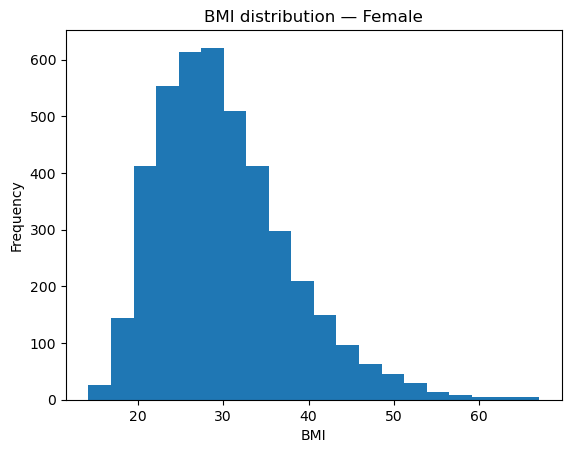

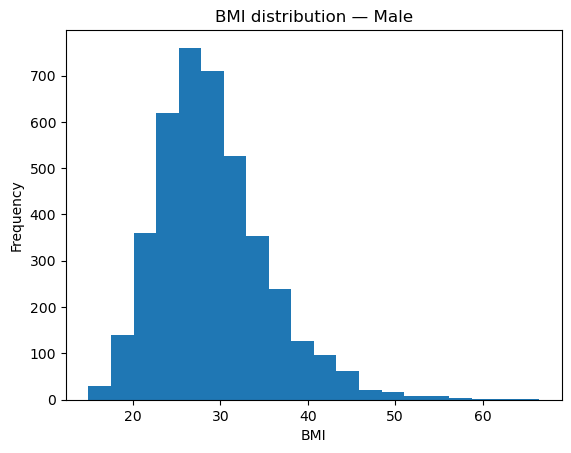

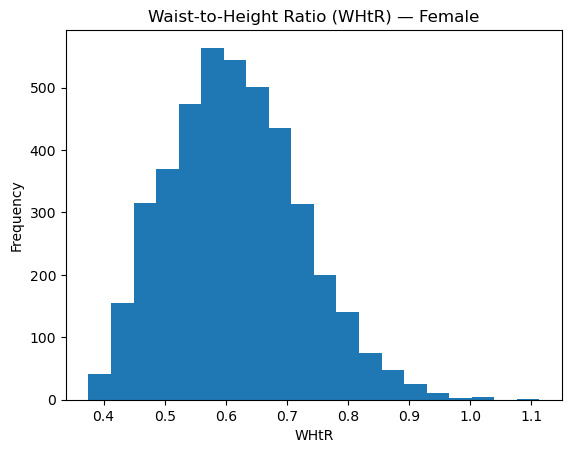

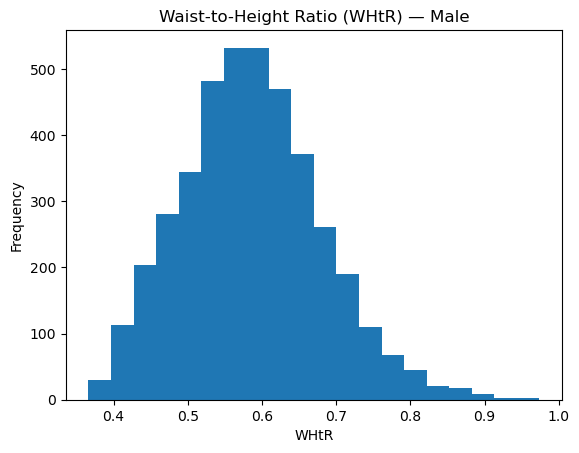

In [2]:
# Single, self-contained Python script that loads the uploaded NHANES BMX CSVs,
# computes key metrics (including BMI), and prints absolute results.
# It also shows two simple histograms (BMI and WHtR by sex) using matplotlib (no custom colors).

import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt

female_path = ("C:/Users/raman/Downloads/nhanes_adult_female_bmx_2020.csv")
male_path   = ("C:/Users/raman/Downloads/nhanes_adult_male_bmx_2020.csv")

def read_nhanes_bmx(path: str, sex_label: str) -> pd.DataFrame:
    # Find the line index where the real header appears (starts with BMXWT)
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    header_idx = None
    for i, line in enumerate(lines):
        if line.strip().startswith('"BMXWT"') or line.strip().startswith('BMXWT'):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError(f"Could not locate header line with BMX fields in: {path}")
    # Read the CSV from that header line
    content = "".join(lines[header_idx:])
    df = pd.read_csv(io.StringIO(content))
    # Normalize column names just in case quotes are present
    df.columns = [c.replace('"','').strip() for c in df.columns]
    # Keep only expected columns if present
    expected_cols = ["BMXWT","BMXHT","BMXARML","BMXLEG","BMXARMC","BMXHIP","BMXWAIST"]
    present = [c for c in expected_cols if c in df.columns]
    df = df[present].copy()
    df["sex"] = sex_label
    return df

# Load both datasets
df_f = read_nhanes_bmx(female_path, "Female")
df_m = read_nhanes_bmx(male_path,   "Male")
df = pd.concat([df_f, df_m], ignore_index=True)

# Derived metrics
df["height_m"] = df["BMXHT"] / 100.0
df["BMI"] = df["BMXWT"] / (df["height_m"]**2)  # kg/m^2
df["WHR"] = df["BMXWAIST"] / df["BMXHIP"]
df["WHtR"] = df["BMXWAIST"] / df["BMXHT"]

# Light filters to avoid divisions by zero or nonsense
mask_valid = (
    (df["BMXWT"] > 0) &
    (df["BMXHT"] > 0) &
    (df["BMXHIP"] > 0) &
    (df["BMXWAIST"] > 0)
)
df = df.loc[mask_valid].copy()

# WHO BMI categories
def bmi_category(bmi: float) -> str:
    if pd.isna(bmi):
        return "Missing"
    if bmi < 18.5: return "Underweight"
    if bmi < 25:   return "Normal"
    if bmi < 30:   return "Overweight"
    return "Obese"

df["BMI_Category"] = df["BMI"].apply(bmi_category)

# ===== Absolute results (printed) =====
print("NHANES Adult Body Measures — Summary (Your Uploaded 2020 Files)")
print("="*72)
print(f"Total rows (after basic filtering): {len(df):,}")
print("Rows by sex:")
print(df["sex"].value_counts().to_string())
print()

def summary_by_sex(metric: str) -> pd.DataFrame:
    g = df.groupby("sex")[metric].agg(["count","mean","std","min","median","max"])
    return g.round(2)

print("Height (cm) — by sex")
print(summary_by_sex("BMXHT").to_string())
print()

print("Weight (kg) — by sex")
print(summary_by_sex("BMXWT").to_string())
print()

print("BMI (kg/m^2) — by sex")
print(summary_by_sex("BMI").to_string())
print()

# BMI category distribution by sex (counts and percentages)
bmi_ct = pd.crosstab(df["sex"], df["BMI_Category"]).reindex(columns=["Underweight","Normal","Overweight","Obese"], fill_value=0)
bmi_pct = (bmi_ct.div(bmi_ct.sum(axis=1), axis=0) * 100).round(1)
print("BMI Categories — Count by sex")
print(bmi_ct.to_string())
print()
print("BMI Categories — Percentage by sex")
print(bmi_pct.to_string())
print()

# Correlations among key metrics
corr_cols = ["BMXWT", "BMXHT", "BMXWAIST", "BMXHIP", "BMI", "WHR", "WHtR"]
present_corr = [c for c in corr_cols if c in df.columns]
corr = df[present_corr].corr().round(3)
print("Correlation matrix (overall):")
print(corr.to_string())
print()

# ===== Simple plots (each in its own figure; no custom colors) =====
for sex in ["Female", "Male"]:
    sub = df[df["sex"] == sex]
    plt.figure()
    plt.hist(sub["BMI"].dropna(), bins=20)
    plt.title(f"BMI distribution — {sex}")
    plt.xlabel("BMI")
    plt.ylabel("Frequency")
    plt.show()

for sex in ["Female", "Male"]:
    sub = df[df["sex"] == sex]
    plt.figure()
    plt.hist(sub["WHtR"].dropna(), bins=20)
    plt.title(f"Waist-to-Height Ratio (WHtR) — {sex}")
    plt.xlabel("WHtR")
    plt.ylabel("Frequency")
    plt.show()
